## Librerias Necesarias

In [1]:
import numpy as np
import CPMP_attention_model as cpmp_att
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pymongo
import tensorflow as tf

## Funciones para entrenamiento y predicciones

In [2]:
#************ | expand_dims_cpmp() | **************#
# El proposito de esta función es expandir las     #
# dimensiones de un estado menor para que pueda    #
# ser predicho un por modelo para un estado mayor. #
#                                                  #
# Input:                                           #
#     - data: Lista de matrices con todos los      #
#             estados.                             #
#     - labels: lista de posibles stacks de origen #
#               o destino.                         #
#     - stacks: Cantidad de stacks permitidos por  #    
#               el modelo.                         #
#     - height: Altura máxima de los stacks        #
#               permitidos por el modelo.          #
#                                                  #
# Output:                                          #
#      Retona un arreglo de los datos              #
#      redimensionados con sus respectivos labels. #
def expand_dims_cpmp(data, labels, stacks, height):
    size = data.shape[1]
    tuple_data = zip(data, labels)
    data_2 = []
    labels_2 = []

    for matrix, label in tuple_data:
        matrix = matrix.tolist()
        label = label.tolist()
        for i in range(stacks - size):
            matrix.append([1] + [1 for n in range(height)])
            label.append(0)

        data_2.append(matrix)
        labels_2.append(label)

    return np.array(data_2), np.array(labels_2)

In [3]:
#************* | is_equal() | **************#
# El proposito de esta función es verificar #
# si los datos ingresados en dos arreglos   #
# son exactamente iguales independiente de  #
# su posición.                              #
#                                           #
# Input:                                    #
#     - array1: Primer arreglo que se       #
#               desea comparar.             #
#     - array2: Segundo arreglo que se      #
#               desea comparar.             #
# Output:                                   #
#     Retorna true en el caso de tener      #
#     cada dato exactamente igual o         #
#     False en caso contrario.              #
def is_equal(array1, array2):
    size = len(array1)
    cant = 0
    array1.sort()
    array2.sort()

    for i in range(size):
        if array1[i] == array2[i]:
            cant += 1

    if cant == size: return True

    return False

In [4]:
#***************** | precision() | ***************#
# El proposito de esta función es verificar si    #
# los valores predichos por una red neuronal son  #
# correctos o no.                                 #
#                                                 #
# Input:                                          #
#     - y_predict: Valores predichos por el       #
#                  mecanismo de machine learning. #
#     - y_test: Valores reales de los casos       #
#               predichos.                        #
# Output:                                         #
#     Retorna una proporción entre los valores    #
#     predichos correctamente sobre la cantidad   #
#     de datos.                                   #
def precision(y_predict, y_test):
    size = len(y_predict)
    predict = 0

    for i in range(size):
        if np.argmax(y_predict[i]) == np.argmax(y_test[i]):
            predict += 1
    
    return predict / size

In [5]:
#************** | precision_for_multiclass() | ***************#
# El proposito de esta función es verificar si los valores    #
# predichos por un mecanismo de machine learning para         #
# clasificación multiclase están correctos o no.              #
#                                                             # 
# Input:                                                      #
#     - y_predict: Valores predichos por el mecanismo de      #
#                  machine learning.                          #
#     - y_test: Valores reales de cada caso.                  #
# Output:                                                     #
#     Retorna una proporción entre los valores predichos      #
#     correctamente sobre la cantidad total de casos.         #
def cosine_Similarity(y_predict, y_test):
    size = len(y_predict)
    suma = 0

    for i in range(size):
        result = np.dot(y_predict[i], y_test[i]) / (np.linalg.norm(y_predict[i]) * np.linalg.norm(y_test[i]))
        suma += result
    
    return suma / size

In [6]:
def load_gpu():
    if tf.config.list_physical_devices('GPU'):
        print("GPU encontrada.")
    else:
        print("No se encontró una GPU. Asegúrate de que los controladores estén instalados.")

## Funciones para cargar data
### Local

In [7]:
#************** | load_data() | ************#
# El proposito de esta función es cargar    #
# los datos almacenados en un csv para el   #
# entrenamiento de la red neuronal.         #
#                                           #
# Input:                                    #
#     - name: Nombre del archivo con su     #
#             dirección correspondiente     #
#             sin el .csv.                  #
#                                           #
# Output:                                   #
#      Retorna 3 arreglos, el primero       #
#      corresponde a una lista de estados,  #
#      el segundo a una lista de labels     #
#      de stacks de origen y por último una #
#      lista de posibles stacks de destino. #
def load_data(name):
    data = []
    labels_1 = []
    labels_2 = []

    with open(name + '.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)
            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(labels_1), np.stack(labels_2)

In [8]:
def load_data_2(name: str) -> tuple:
    data = []
    labels = []

    with open(name + '.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)

            data.append(matrix)
            labels.append(label_1)

            archivo.readline()

    return np.stack(data), np.stack(labels)

In [9]:
def load_data_multi(name):
    data = []
    data_2 = []
    labels_1 = []
    labels_2 = []

    with open(name + '_so.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)

            archivo.readline()

    with open(name + '_sd.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data_2.append(matrix)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(data_2), np.stack(labels_1), np.stack(labels_2)

### MongoDB

In [10]:
def connect_to_server(uri):
    try: 
        client = pymongo.MongoClient(uri, serverSelectionTimeoutMS= 1000)
        client.server_info()
        print('Conection Success')

        return client
    
    except pymongo.errors.ServerSelectionTimeoutError as identifier:
        print('tiempo excedido' + identifier)

    except pymongo.errors.ConnectionFailure as conection_Error:
        print('Error al conectarse a mongodb' + conection_Error)

In [11]:
def load_data_mongo(collection):
    data = []
    labels = []

    for states in collection.find():
        data.append(states['State'])
        labels.append(states['Labels'])
    
    return np.stack(data), np.stack(labels)

In [12]:
def load_data_mongo_2(collection):
    data = []
    labels_1 = []
    labels_2 = []

    for states in collection.find():
        data.append(states['State'])
        labels_1.append(states['Labels_1'])
        labels_2.append(states['Labels_2'])
    
    return np.stack(data), np.stack(labels_1), np.stack(labels_2)

In [14]:
MONGO_URI_MODEL_V1 = "mongodb+srv://<username>:<password>@cpmp.g70sihj.mongodb.net/"
MONGO_URI_MODEL_V1_5 = "mongodb+srv://<username>:<password>@slinking.nxcivgv.mongodb.net/"
MONGO_URI_MODEL_V2 = 'mongodb+srv://<username>:<password>@cluster0.p9y0etq.mongodb.net/'

In [ ]:
client_v1_5 = connect_to_server(MONGO_URI_MODEL_V1_5)

# Cargar Data
## Local

In [ ]:
data_5x5, labels_5x5 = load_data_2('Data_CPMP/Data_Model_v2/data_5x5_Multiple')

In [ ]:
data_7x7, labels_7x7 = load_data_2('data/data_7x7_Multiple')

In [12]:
data_7x7, labels_7x7 = load_data_2('data/data_7x7_Multiple')

## MongoDB

### Modelo V1

In [ ]:
client_v1 = connect_to_server(MONGO_URI_MODEL_V1)

base_de_datos = client_v1.data_Model_v1
data_5x5, labels_1_5x5, labels_2_5x5 = load_data_mongo_2(base_de_datos.data_5x5)

cliente_v1.close()

In [ ]:
client_v1 = connect_to_server(MONGO_URI_MODEL_V1)

base_de_datos = client_v1.data_Model_v1
data_7x7, labels_1_7x7, labels_2_7x7 = load_data_mongo_2(base_de_datos.data_7x7)

cliente_v1.close()

In [ ]:
client_v1 = connect_to_server(MONGO_URI_MODEL_V1)

base_de_datos = client_v1.data_Model_v1
data_10x10, labels_1_10x10, labels_2_10x10 = load_data_mongo_2(base_de_datos.data_10x10)

cliente_v1.close()

In [ ]:
client_v1 = connect_to_server(MONGO_URI_MODEL_V1)

base_de_datos = client_v1.data_Model_v1
data_10x7, labels_1_10x7, labels_2_10x7 = load_data_mongo_2(base_de_datos.data_10x7)

cliente_v1.close()

In [ ]:
client_v1 = connect_to_server(MONGO_URI_MODEL_V1)

base_de_datos = client_v1.data_Model_v1
data_3x5, labels_1_3x5, labels_2_3x5 = load_data_mongo_2(base_de_datos.data_3x5)

cliente_v1.close()

### Modelo V1.5

In [ ]:
client_v1_5 = connect_to_server(MONGO_URI_MODEL_V1_5)

base_de_datos = client_v1_5['CPMP_Data_Model_v1-5']
data_so_7x7, labels_so_7x7 = load_data_mongo(base_de_datos.data_7x7_so)
data_sd_7x7, labels_sd_7x7 = load_data_mongo(base_de_datos.data_7x7_sd)

cliente_v1_5.close()

### Modelo V2

In [16]:
client_v2 = connect_to_server(MONGO_URI_MODEL_V2)

base_de_datos = client_v2.data_Model_v2
data_5x5, labels_5x5 = load_data_mongo(base_de_datos.data_5x5)

cliente_v2.close()

In [32]:
client_v2 = connect_to_server(MONGO_URI_MODEL_V2)

base_de_datos = client_v2.data_Model_v2
data_7x7, labels_7x7 = load_data_mongo(base_de_datos.data_7x7)

cliente_v2.close()

# Cargar Modelos

In [48]:
model_5x5_multi = cpmp_att.CPMP_attention_model()
model_5x5_multi.set_model('models/modelo_5x5__.h5')

In [ ]:
model_7x7_multi = cpmp_att.CPMP_attention_model()
model_7x7_multi.set_model('models/model_cpmp_7x7.h5')

# Modelo con Varias Salidas

## Modelo 5x5

In [17]:
load_gpu()

No se encontró una GPU. Asegúrate de que los controladores estén instalados.


In [20]:
model_5x5_multi = cpmp_att.CPMP_attention_model()

In [21]:
model_5x5_multi.create_model(num_layer_attention_add= 2, heads= 5, S= 5, H= 5, optimizer= 'Adam')

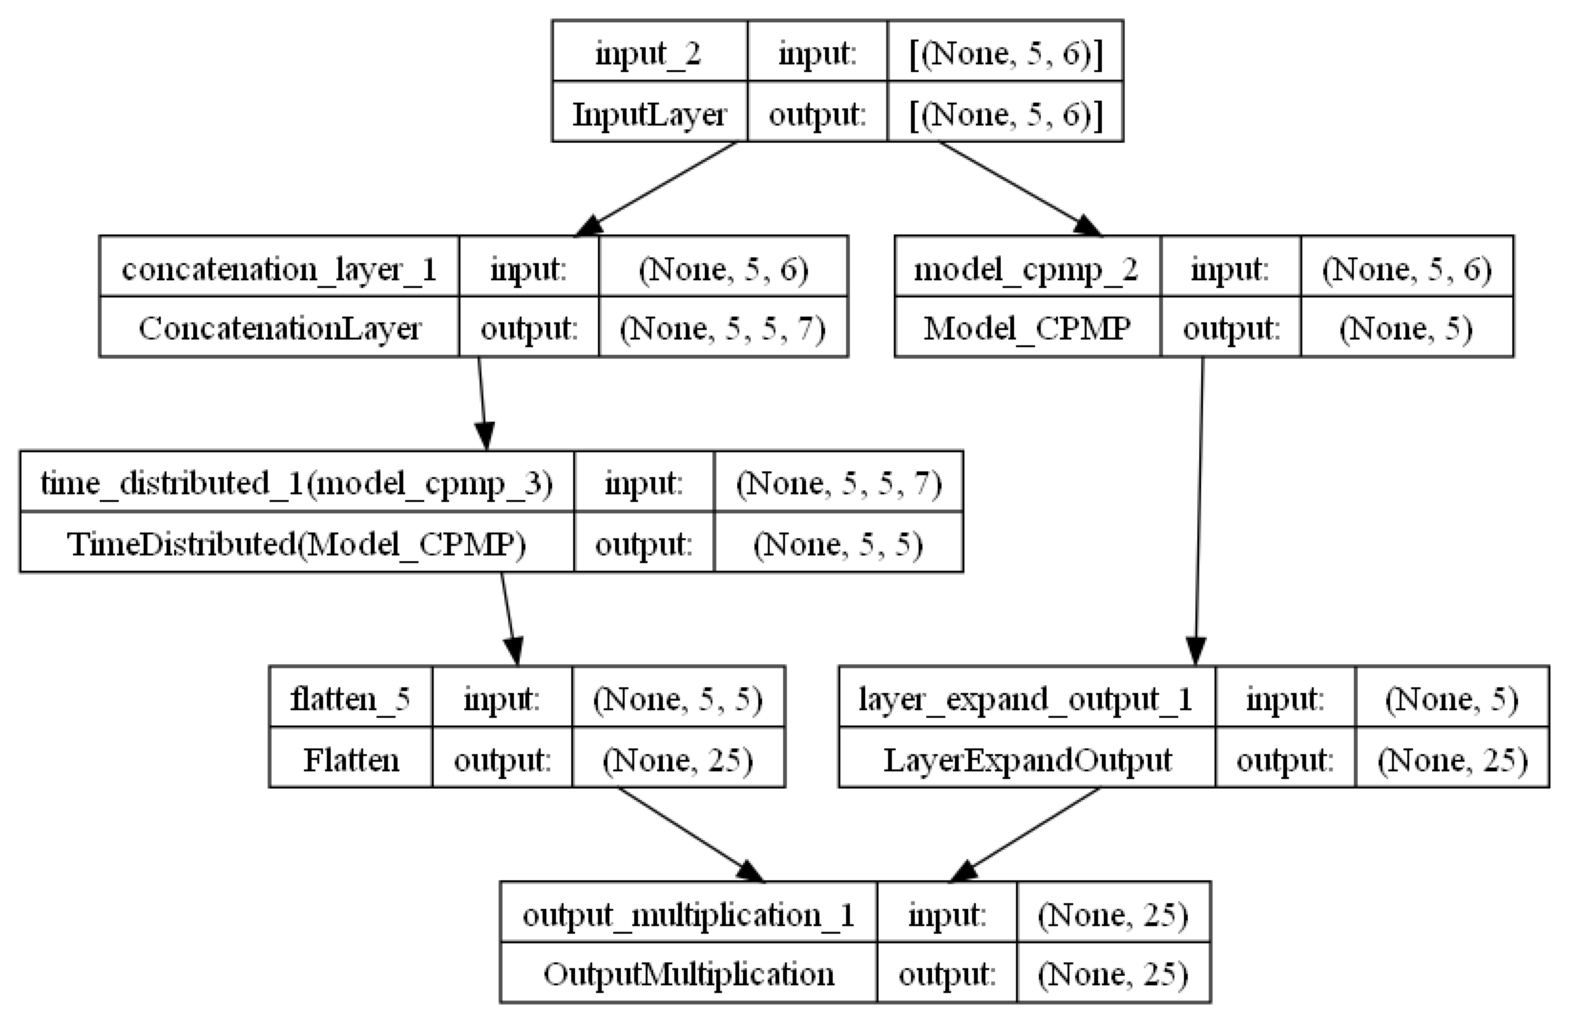

In [22]:
model_5x5_multi.plot_model(name= 'images_models/model_cpmp_multi')

### Entrenamiento

In [23]:
X_train_5x5, X_test_5x5, y_train_5x5, y_test_5x5 = train_test_split(data_5x5, labels_5x5, 
                                                                    test_size= 0.2, random_state= 42)

In [24]:
records = model_5x5_multi.fit(X_train_5x5, y_train_5x5, epochs= 50, verbose= True)

Epoch 1/50
6250/6250 [==============================] - 77s 11ms/step - loss: 0.1161 - mae: 0.0740 - mse: 0.0357
Epoch 2/50
6250/6250 [==============================] - 56s 9ms/step - loss: 0.0766 - mae: 0.0493 - mse: 0.0241
Epoch 3/50
6250/6250 [==============================] - 57s 9ms/step - loss: 0.0634 - mae: 0.0400 - mse: 0.0196
Epoch 4/50
6250/6250 [==============================] - 58s 9ms/step - loss: 0.0580 - mae: 0.0363 - mse: 0.0179
Epoch 5/50
6250/6250 [==============================] - 58s 9ms/step - loss: 0.0543 - mae: 0.0337 - mse: 0.0166
Epoch 6/50
6250/6250 [==============================] - 59s 9ms/step - loss: 0.0519 - mae: 0.0322 - mse: 0.0159
Epoch 7/50
6250/6250 [==============================] - 69s 11ms/step - loss: 0.0502 - mae: 0.0310 - mse: 0.0154
Epoch 8/50
6250/6250 [==============================] - 90s 14ms/step - loss: 0.0490 - mae: 0.0303 - mse: 0.0151
Epoch 9/50
6250/6250 [==============================] - 87s 14ms/step - loss: 0.0475 - mae: 0.0295 - 

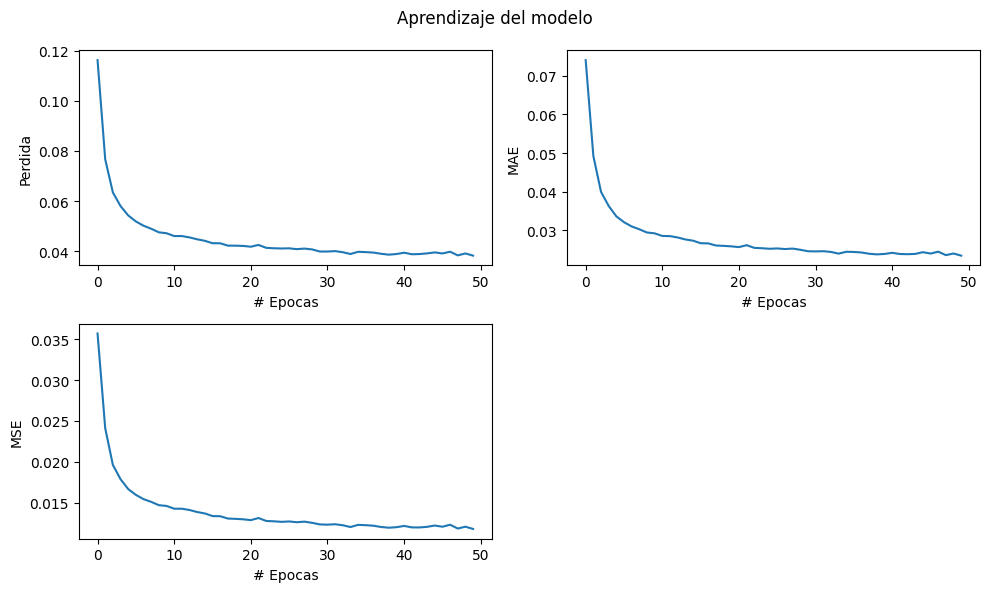

In [25]:
plt.figure(figsize= (10, 6))

plt.subplot(2, 2, 1)
plt.xlabel("# Epocas")
plt.ylabel("Perdida")
plt.plot(records.history['loss'])

plt.subplot(2, 2, 2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(records.history['mae'])

plt.subplot(2, 2, 3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(records.history['mse'])

plt.suptitle('Aprendizaje del modelo')
plt.tight_layout()
plt.show()

In [26]:
predict = model_5x5_multi.predict(X_test_5x5)

In [27]:
results_1 = cosine_Similarity(predict, y_test_5x5)
results_2 = mean_absolute_error(y_test_5x5, predict)
results_3 = mean_squared_error(y_test_5x5, predict)

print(f'Precisión del modelo: {round(results_1 * 100, 3)}%')
print(f'Error Absoluto Medio: {round(results_2 * 100, 3)}%')
print(f'Error cuadratico medio: {round(results_3 * 100, 3)}%')

Precisión del modelo: 94.509%
Error Absoluto Medio: 2.183%
Error cuadratico medio: 1.107%


## Modelo 7x7

In [44]:
model_7x7_multi = cpmp_att.CPMP_attention_model()

In [45]:
model_7x7_multi.create_model(num_layer_attention_add= 2, heads= 5, S= 7, H= 7, optimizer= 'Adam')

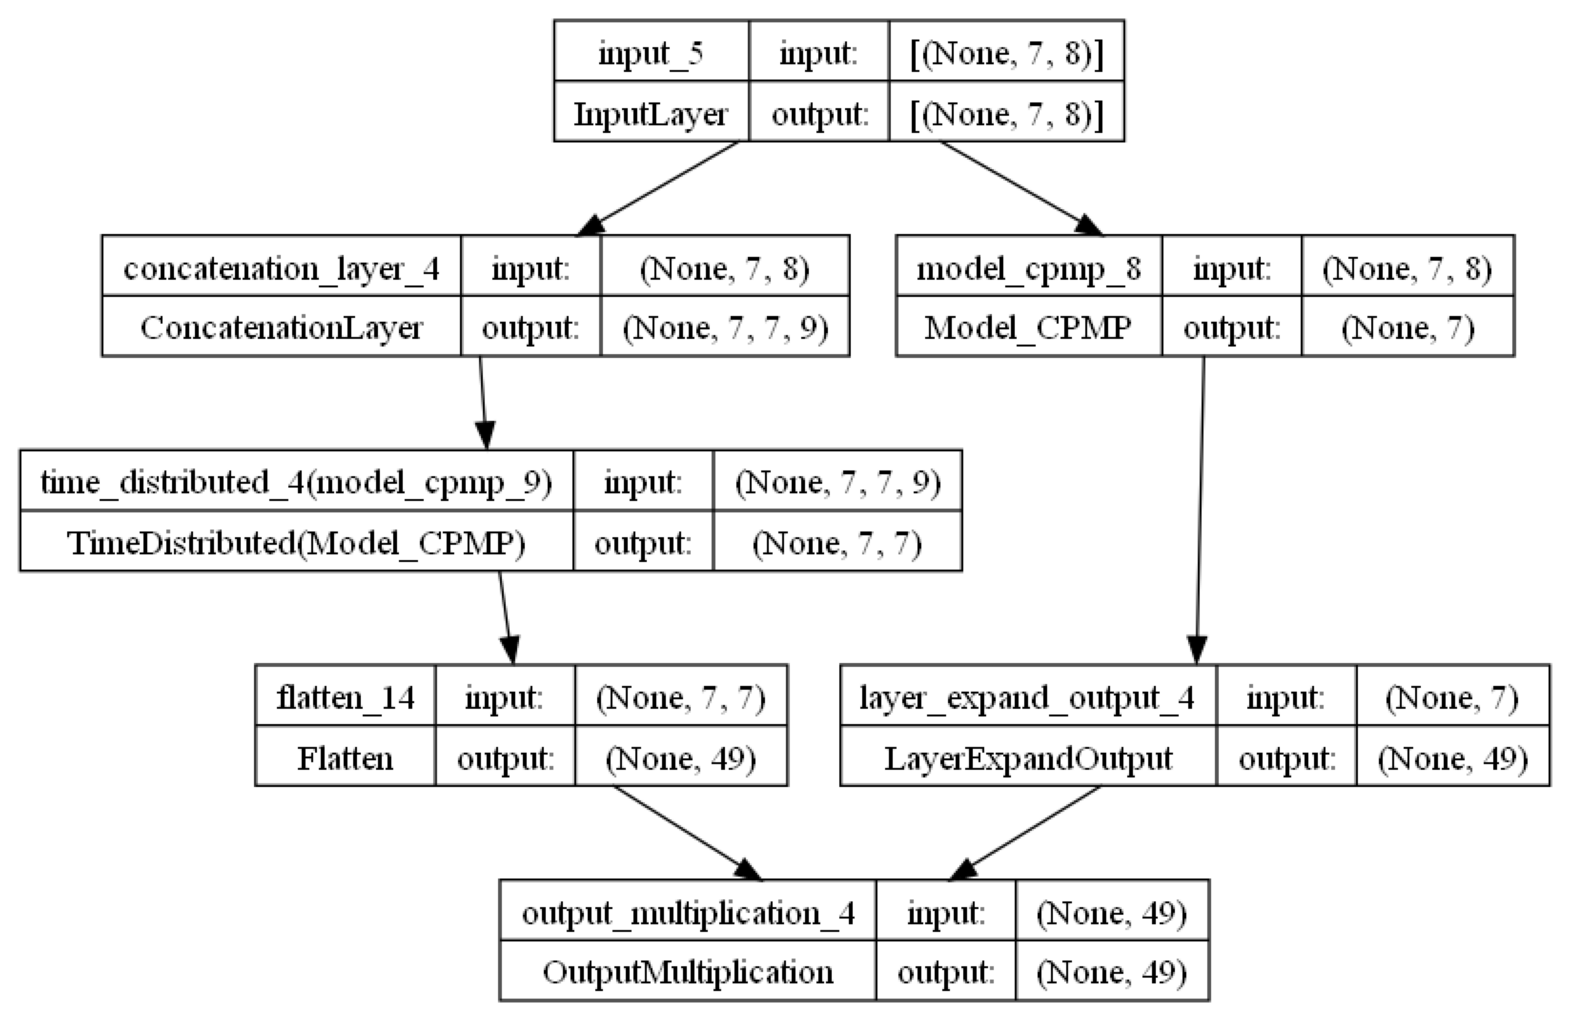

In [46]:
model_7x7_multi.plot_model(name= 'images_models/model_cpmp_multi')

### Entrenamiento

In [47]:
X_train_7x7, X_test_7x7, y_train_7x7, y_test_7x7 = train_test_split(data_7x7, labels_7x7, 
                                                                    test_size= 0.2, random_state= 42)

In [48]:
records = model_7x7_multi.fit(X_train_7x7, y_train_7x7, epochs= 50, verbose= True)

Epoch 1/50
2500/2500 [==============================] - 39s 13ms/step - loss: 0.1207 - mae: 0.0687 - mse: 0.0335
Epoch 2/50
2500/2500 [==============================] - 32s 13ms/step - loss: 0.0642 - mae: 0.0403 - mse: 0.0198
Epoch 3/50
2500/2500 [==============================] - 33s 13ms/step - loss: 0.0577 - mae: 0.0358 - mse: 0.0177
Epoch 4/50
2500/2500 [==============================] - 33s 13ms/step - loss: 0.0555 - mae: 0.0343 - mse: 0.0170
Epoch 5/50
2500/2500 [==============================] - 33s 13ms/step - loss: 0.0540 - mae: 0.0334 - mse: 0.0166
Epoch 6/50
2500/2500 [==============================] - 33s 13ms/step - loss: 0.0537 - mae: 0.0332 - mse: 0.0165
Epoch 7/50
2500/2500 [==============================] - 33s 13ms/step - loss: 0.0524 - mae: 0.0324 - mse: 0.0161
Epoch 8/50
2500/2500 [==============================] - 33s 13ms/step - loss: 0.0525 - mae: 0.0325 - mse: 0.0162
Epoch 9/50
2500/2500 [==============================] - 34s 14ms/step - loss: 0.0514 - mae: 0.03

In [51]:
predict = model_7x7_multi.predict(X_test_7x7)

In [52]:
results_1 = cosine_Similarity(predict, y_test_7x7)
results_2 = mean_absolute_error(y_test_7x7, predict)
results_3 = mean_squared_error(y_test_7x7, predict)

print(f'Precisión del modelo: {round(results_1 * 100, 3)}%')
print(f'Error Absoluto Medio: {round(results_2 * 100, 3)}%')
print(f'Error cuadratico medio: {round(results_3 * 100, 3)}%')

Precisión del modelo: 90.464%
Error Absoluto Medio: 2.014%
Error cuadratico medio: 1.045%
